In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **TensorFlow GPU Initialization**

In [85]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU enabled")
    except RuntimeError as e:
        print(e)


GPU enabled


# **Library Imports and Reproducibility Setup**

In [86]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Finance data
import yfinance as yf

# Image processing
import cv2
from PIL import Image

# ML / DL
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# Stats
from scipy.stats import norm

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# **Stock Price Data Acquisition and Preprocessing**

In [87]:
ticker = "TSLA"

data = yf.download(
    ticker,
    start="2010-01-01",
    end="2019-12-31",
    progress=False
)

data = data[['High', 'Low', 'Close']]
data.dropna(inplace=True)

print("Total rows:", len(data))
data.head()


Total rows: 2393


/tmp/ipython-input-1599143259.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(


Price           High       Low     Close
Ticker          TSLA      TSLA      TSLA
Date                                    
2010-06-29  1.666667  1.169333  1.592667
2010-06-30  2.028000  1.553333  1.588667
2010-07-01  1.728000  1.351333  1.464000
2010-07-02  1.540000  1.247333  1.280000
2010-07-06  1.333333  1.055333  1.074000

# **Next-Day Return Computation and Rare Event Thresholding**

In [88]:
# Ensure Close is a Series (fixes yfinance multi-column issue)
if isinstance(data['Close'], pd.DataFrame):
    close = data['Close'].iloc[:, 0]
else:
    close = data['Close']

# Next-day close
data['next_close'] = close.shift(-1)

# Day-over-day percent change
data['pct_change'] = (data['next_close'] - close) / close

# Drop last row
data.dropna(inplace=True)

# Choose rarity level (99, 95, or 90)
percentile = 95
threshold = np.percentile(data['pct_change'].values, percentile)

# **Snake Pattern Image Construction from Sliding Window Data**

In [89]:
def create_snake_image(window, img_size):
    window_norm = np.zeros_like(window)

    for i in range(window.shape[0]):
        row = window[i]
        row = 255 * (row - row.min()) / (row.max() - row.min() + 1e-8)
        window_norm[i] = row

    window_norm = window_norm.astype(np.uint8)

    img = np.zeros((img_size, img_size, 3), dtype=np.uint8)
    idx = 0

    for r in range(img_size):
        row_vals = window_norm[idx:idx + img_size]
        if r % 2 == 1:
            row_vals = row_vals[::-1]
        img[r] = row_vals
        idx += img_size

    return img


# **Event Label Reconstruction and Validation**

In [90]:
# SAFETY CHECK: recreate event column if missing
if 'event' not in data.columns:
    print("Recreating event column...")

    # Ensure Close is a Series
    if isinstance(data['Close'], pd.DataFrame):
        close = data['Close'].iloc[:, 0]
    else:
        close = data['Close']

    data['next_close'] = close.shift(-1)
    data['pct_change'] = (data['next_close'] - close) / close
    data.dropna(inplace=True)

    percentile = 95  # change if needed
    threshold = np.percentile(data['pct_change'].values, 100 - percentile)

    data['event'] = (data['pct_change'] <= threshold).astype(int)

print("Event column OK")
print(data['event'].value_counts())


Recreating event column...
Event column OK
event
0    2271
1     120
Name: count, dtype: int64


# **Sliding Window Image Generation and Dataset Construction**

In [91]:
WINDOW = 25
IMG_DIM = int(np.sqrt(WINDOW))

images = []
labels = []
dates = []

for i in range(WINDOW, len(data)):
    window = data.iloc[i-WINDOW:i][['High', 'Low', 'Close']].values

    img = create_snake_image(window, IMG_DIM)
    img = cv2.resize(img, (224, 224))

    images.append(img)
    labels.append(int(data.iloc[i]['event']))
    dates.append(data.index[i])

images = np.asarray(images, dtype=np.uint8)
labels = np.asarray(labels, dtype=np.int32)

print("Images shape:", images.shape)
print("Label counts:", np.bincount(labels))


/tmp/ipython-input-3395302108.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-3395302108.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-3395302108.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-3395302108.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-3395302108.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise 

Images shape: (2366, 224, 224, 3)
Label counts: [2250  116]


# **Reload RAW data**

In [92]:
import yfinance as yf
import pandas as pd

raw_data = yf.download(
    "TSLA",
    start="2010-01-01",
    end="2019-12-31",
    progress=False
)[['High','Low','Close']]

raw_data.dropna(inplace=True)

raw_data.head()


/tmp/ipython-input-1643401559.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(


Price           High       Low     Close
Ticker          TSLA      TSLA      TSLA
Date                                    
2010-06-29  1.666667  1.169333  1.592667
2010-06-30  2.028000  1.553333  1.588667
2010-07-01  1.728000  1.351333  1.464000
2010-07-02  1.540000  1.247333  1.280000
2010-07-06  1.333333  1.055333  1.074000

# **Align event labels with raw prices**

In [93]:
# Recreate labels on RAW data
# Ensure Close is a Series (fixes yfinance multi-column issue)
if isinstance(raw_data['Close'], pd.DataFrame):
    close = raw_data['Close'].iloc[:, 0]
else:
    close = raw_data['Close']

raw_data['next_close'] = close.shift(-1)
raw_data['pct_change'] = (raw_data['next_close'] - close) / close
raw_data.dropna(inplace=True)

# Example: 5% imbalance (change if you want)
percentile = 95
threshold = np.percentile(raw_data['pct_change'], 100 - percentile)
raw_data['event'] = (raw_data['pct_change'] <= threshold).astype(int)

raw_data['event'].value_counts()

event
0    2272
1     120
Name: count, dtype: int64

# **Select valid 25-day windows**

In [94]:
WINDOW = 25

event_indices = raw_data.index[raw_data['event'] == 1]
nonevent_indices = raw_data.index[raw_data['event'] == 0]

def get_valid_window(idx):
    pos = raw_data.index.get_loc(idx)
    if pos < WINDOW:
        return None
    return raw_data.iloc[pos-WINDOW:pos][['High','Low','Close']]

# Pick first valid examples
event_window = None
for idx in event_indices:
    w = get_valid_window(idx)
    if w is not None:
        event_window = w
        break

nonevent_window = None
for idx in nonevent_indices:
    w = get_valid_window(idx)
    if w is not None:
        nonevent_window = w
        break

event_window.shape, nonevent_window.shape


((25, 3), (25, 3))

# **Correct HLC Line Plots**

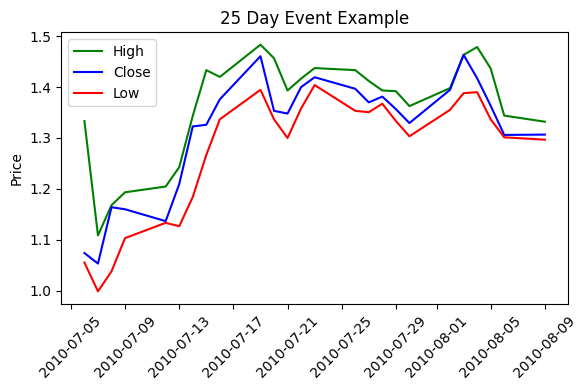

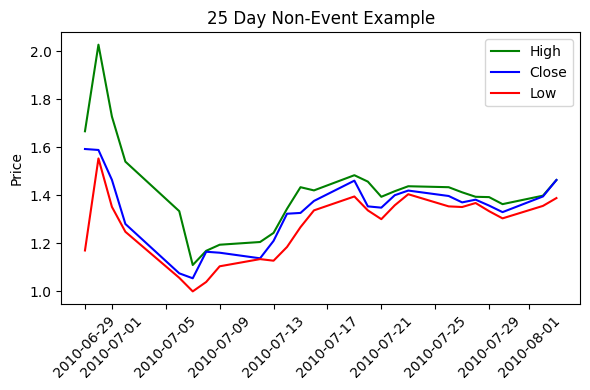

In [95]:
import matplotlib.pyplot as plt

def plot_hlc(window, title):
    plt.figure(figsize=(6,4))
    plt.plot(window.index, window['High'], label='High', color='green')
    plt.plot(window.index, window['Close'], label='Close', color='blue')
    plt.plot(window.index, window['Low'], label='Low', color='red')
    plt.ylabel("Price")
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_hlc(event_window, "25 Day Event Example")
plot_hlc(nonevent_window, "25 Day Non-Event Example")


In [96]:
import numpy as np

def window_to_image(window):
    window = window.values
    img_dim = int(np.sqrt(len(window)))

    norm = np.zeros_like(window)
    for i in range(window.shape[0]):
        row = window[i]
        norm[i] = 255 * (row - row.min()) / (row.max() - row.min() + 1e-8)

    norm = norm.astype(np.uint8)

    img = np.zeros((img_dim, img_dim, 3), dtype=np.uint8)
    idx = 0
    for r in range(img_dim):
        row_vals = norm[idx:idx+img_dim]
        if r % 2 == 1:
            row_vals = row_vals[::-1]
        img[r] = row_vals
        idx += img_dim

    return img


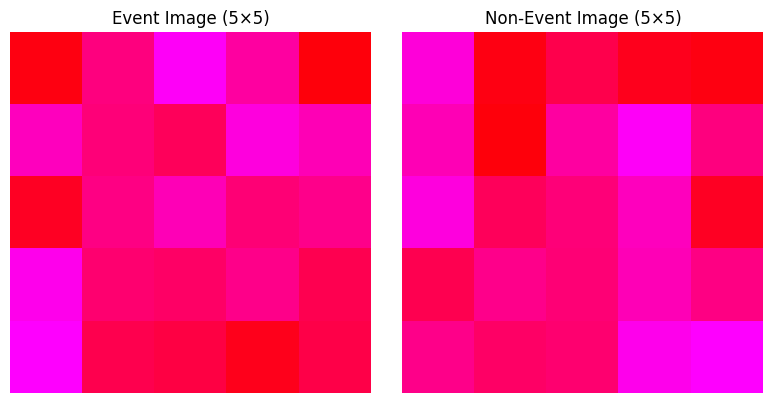

In [97]:
event_img = window_to_image(event_window)
nonevent_img = window_to_image(nonevent_window)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(event_img)
plt.title("Event Image (5×5)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(nonevent_img)
plt.title("Non-Event Image (5×5)")
plt.axis("off")

plt.tight_layout()
plt.show()


# **Train–Test Split Based on Temporal Order**

In [98]:
mid = len(images) // 2

X_train, X_test = images[:mid], images[mid:]
y_train, y_test = labels[:mid], labels[mid:]

print("Train labels:", np.bincount(y_train))
print("Test labels :", np.bincount(y_test))


Train labels: [1119   64]
Test labels : [1131   52]


In [99]:
print(data.columns)


MultiIndex([(      'High', 'TSLA'),
            (       'Low', 'TSLA'),
            (     'Close', 'TSLA'),
            ('next_close',     ''),
            ('pct_change',     ''),
            (     'event',     '')],
           names=['Price', 'Ticker'])


# **Dataset Integrity Checks and Split Verification**

In [100]:
assert 'event' in data.columns, "event column missing"
assert len(images) == len(labels), "Images / labels mismatch"

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)
print("Train label distribution:", np.bincount(y_train))
print("Test label distribution :", np.bincount(y_test))


Train shape: (1183, 224, 224, 3)
Test shape : (1183, 224, 224, 3)
Train label distribution: [1119   64]
Test label distribution : [1131   52]


In [101]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

print("GPU available:", tf.config.list_physical_devices('GPU'))

base_model = VGG16(
    weights='imagenet',
    include_top=True
)

# Extract 4096-dim feature vector (fc2)
feature_model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('fc2').output
)

feature_model.trainable = False


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **Deep Feature Extraction Using Pretrained VGG16**

In [102]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def extract_features(images, model):
    images = images.astype(np.float32)
    images = preprocess_input(images)
    return model.predict(images, batch_size=32, verbose=1)

F_train = extract_features(X_train, feature_model)
F_test  = extract_features(X_test, feature_model)

print("Feature shapes:", F_train.shape, F_test.shape)


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step
Feature shapes: (1183, 4096) (1183, 4096)


# **Class-Wise Feature Separation for Event and Non-Event Samples**

In [103]:
F_event = F_train[y_train == 1]
F_nonevent = F_train[y_train == 0]

print("Event features:", F_event.shape)
print("Non-event features:", F_nonevent.shape)


Event features: (64, 4096)
Non-event features: (1119, 4096)


# Bootstrap-Based Distance Distribution Modeling Using Manhattan **Metric**

In [104]:
from scipy.stats import norm

def manhattan(a, b):
    return np.sum(np.abs(a - b))

def bootstrap_distributions(F_event, F_nonevent, n_iter=2000):
    k = max(1, len(F_event) // 2)

    ee_dist = []
    en_dist = []

    for _ in range(n_iter):
        e1 = F_event[np.random.choice(len(F_event), k, replace=True)]
        e2 = F_event[np.random.choice(len(F_event), k, replace=True)]
        n1 = F_nonevent[np.random.choice(len(F_nonevent), k, replace=True)]

        ee = np.mean([manhattan(a, b) for a, b in zip(e1, e2)])
        en = np.mean([manhattan(a, b) for a, b in zip(e1, n1)])

        ee_dist.append(ee)
        en_dist.append(en)

    return np.array(ee_dist), np.array(en_dist)

ee_dist, en_dist = bootstrap_distributions(F_event, F_nonevent)


# **Statistical Parameter Estimation of Distance Distributions**

In [105]:
mu_ee, std_ee = ee_dist.mean(), ee_dist.std()
mu_en, std_en = en_dist.mean(), en_dist.std()

print("Event/Event     μ, σ:", mu_ee, std_ee)
print("Event/Non-Event μ, σ:", mu_en, std_en)


Event/Event     μ, σ: 416.81113 20.613852
Event/Non-Event μ, σ: 421.75323 18.98716


# **Probabilistic Event Classification Using Distance Likelihoods**

In [106]:
def classify_feature(f, F_event, mu_ee, std_ee, mu_en, std_en):
    k = max(1, len(F_event) // 2)
    refs = F_event[np.random.choice(len(F_event), k, replace=True)]

    d = np.mean([manhattan(f, r) for r in refs])

    p_ee = norm.pdf(d, mu_ee, std_ee)
    p_en = norm.pdf(d, mu_en, std_en)

    return 1 if p_ee > p_en else 0


# **Test Set Prediction Using Distance-Based Probabilistic Classifier**

In [107]:
y_pred = np.array([
    classify_feature(f, F_event, mu_ee, std_ee, mu_en, std_en)
    for f in F_test
])


# **Performance Evaluation Using Classification Metrics**

In [108]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))


Accuracy : 0.38292476754015214
Precision: 0.045576407506702415
Recall   : 0.6538461538461539
F1 Score : 0.08521303258145363


# **Visualization of Bootstrapped Event Similarity Distributions**

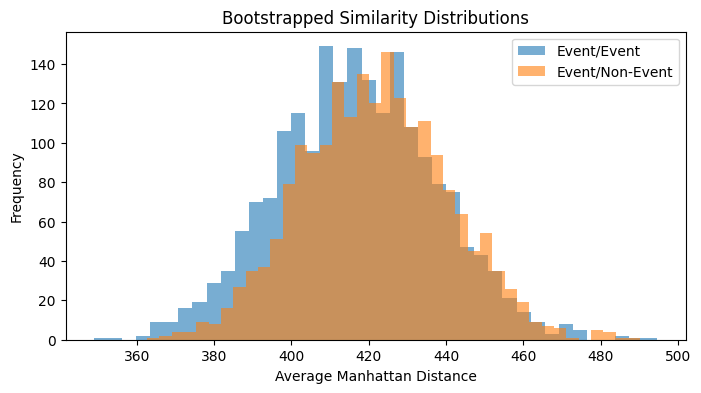

In [109]:
plt.figure(figsize=(8,4))
plt.hist(ee_dist, bins=40, alpha=0.6, label='Event/Event')
plt.hist(en_dist, bins=40, alpha=0.6, label='Event/Non-Event')
plt.legend()
plt.xlabel("Average Manhattan Distance")
plt.ylabel("Frequency")
plt.title("Bootstrapped Similarity Distributions")
plt.show()


# **Experimental Configuration: Rarity Levels and Window Sizes**

In [110]:
RARITY_LEVELS = {
    "1%": 99,
    "5%": 95,
    "10%": 90
}

WINDOW_SIZES = [25, 36, 49, 64, 81]

all_results = []


# **Dynamic Rare-Event Labeling Based on Percentile Thresholds**

In [111]:
def apply_rarity_label(data, percentile):
    data = data.copy()

    # Ensure Close is Series
    if isinstance(data['Close'], pd.DataFrame):
        close = data['Close'].iloc[:, 0]
    else:
        close = data['Close']

    data['next_close'] = close.shift(-1)
    data['pct_change'] = (data['next_close'] - close) / close
    data.dropna(inplace=True)

    threshold = np.percentile(data['pct_change'].values, 100 - percentile)
    data['event'] = (data['pct_change'] <= threshold).astype(int)

    return data


# **Reusable Dataset Construction with Variable Window Sizes**

In [112]:
def build_dataset(data, window):
    img_dim = int(np.sqrt(window))

    images, labels = [], []

    for i in range(window, len(data)):
        window_data = data.iloc[i-window:i][['High','Low','Close']].values
        img = create_snake_image(window_data, img_dim)
        img = cv2.resize(img, (224,224))

        images.append(img)
        labels.append(int(data.iloc[i]['event']))

    images = np.asarray(images, dtype=np.uint8)
    labels = np.asarray(labels, dtype=np.int32)

    mid = len(images) // 2
    return images[:mid], images[mid:], labels[:mid], labels[mid:]


# **Comprehensive Experimental Loop Across Rarity Levels and Window Sizes**

In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for rarity_name, rarity_percentile in RARITY_LEVELS.items():
    print(f"\n==============================")
    print(f" CLASS IMBALANCE: {rarity_name}")
    print(f"==============================")

    data_r = apply_rarity_label(data, rarity_percentile)
    print("Label distribution:")
    print(data_r['event'].value_counts())

    for WINDOW in WINDOW_SIZES:
        print(f"\n--- Window Size {WINDOW} ---")

        X_train, X_test, y_train, y_test = build_dataset(data_r, WINDOW)

        print("Train labels:", np.bincount(y_train))
        print("Test labels :", np.bincount(y_test))

        # --- CNN feature extraction (GPU) ---
        F_train = extract_features(X_train, feature_model)
        F_test  = extract_features(X_test, feature_model)

        # --- Split classes ---
        F_event = F_train[y_train == 1]
        F_nonevent = F_train[y_train == 0]

        if len(F_event) < 2:
            print("⚠️ Too few events — skipping")
            continue

        # --- Bootstrap distributions ---
        ee_dist, en_dist = bootstrap_distributions(F_event, F_nonevent)

        mu_ee, std_ee = ee_dist.mean(), ee_dist.std()
        mu_en, std_en = en_dist.mean(), en_dist.std()

        # --- Classification ---
        y_pred = np.array([
            classify_feature(f, F_event, mu_ee, std_ee, mu_en, std_en)
            for f in F_test
        ])

        # --- Metrics ---
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"Accuracy : {acc:.3f}")
        print(f"Precision: {prec:.3f}")
        print(f"Recall   : {rec:.3f}")
        print(f"F1 Score : {f1:.3f}")

        all_results.append([
            rarity_name, WINDOW, acc, prec, rec, f1
        ])



 CLASS IMBALANCE: 1%
Label distribution:
event
0    2366
1      24
Name: count, dtype: int64

--- Window Size 25 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1170   12]
Test labels : [1173   10]
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step
Accuracy : 0.577
Precision: 0.012
Recall   : 0.600
F1 Score : 0.023

--- Window Size 36 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1165   12]
Test labels : [1167   10]
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step
Accuracy : 0.602
Precision: 0.009
Recall   : 0.400
F1 Score : 0.017

--- Window Size 49 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1158   12]
Test labels : [1161   10]
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step
Accuracy : 0.583
Precision: 0.002
Recall   : 0.100
F1 Score : 0.004

--- Window Size 64 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1151   12]
Test labels : [1153   10]
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step
Accuracy : 0.641
Precision: 0.010
Recall   : 0.400
F1 Score : 0.019

--- Window Size 81 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1142   12]
Test labels : [1145   10]
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step
Accuracy : 0.607
Precision: 0.007
Recall   : 0.300
F1 Score : 0.013

 CLASS IMBALANCE: 5%
Label distribution:
event
0    2270
1     120
Name: count, dtype: int64

--- Window Size 25 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1118   64]
Test labels : [1131   52]
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step
Accuracy : 0.434
Precision: 0.050
Recall   : 0.654
F1 Score : 0.092

--- Window Size 36 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1114   63]
Test labels : [1125   52]
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step
Accuracy : 0.438
Precision: 0.050
Recall   : 0.654
F1 Score : 0.093

--- Window Size 49 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1108   62]
Test labels : [1119   52]
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step
Accuracy : 0.418
Precision: 0.049
Recall   : 0.654
F1 Score : 0.091

--- Window Size 64 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1102   61]
Test labels : [1111   52]
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step
Accuracy : 0.518
Precision: 0.045
Recall   : 0.481
F1 Score : 0.082

--- Window Size 81 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1094   60]
Test labels : [1103   52]
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step
Accuracy : 0.583
Precision: 0.054
Recall   : 0.500
F1 Score : 0.097

 CLASS IMBALANCE: 10%
Label distribution:
event
0    2151
1     239
Name: count, dtype: int64

--- Window Size 25 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1051  131]
Test labels : [1079  104]
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step
Accuracy : 0.489
Precision: 0.104
Recall   : 0.635
F1 Score : 0.179

--- Window Size 36 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1049  128]
Test labels : [1073  104]
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step
Accuracy : 0.331
Precision: 0.094
Recall   : 0.760
F1 Score : 0.167

--- Window Size 49 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1043  127]
Test labels : [1067  104]
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step
Accuracy : 0.548
Precision: 0.103
Recall   : 0.529
F1 Score : 0.172

--- Window Size 64 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1039  124]
Test labels : [1059  104]
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step
Accuracy : 0.519
Precision: 0.089
Recall   : 0.471
F1 Score : 0.149

--- Window Size 81 ---


/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels.append(int(data.iloc[i]['event']))
/tmp/ipython-input-118452880.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

Train labels: [1031  123]
Test labels : [1051  104]
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step
Accuracy : 0.568
Precision: 0.106
Recall   : 0.510
F1 Score : 0.175


# **Aggregation of Experimental Results into Summary Table**

In [114]:
results_df = pd.DataFrame(
    all_results,
    columns=["Class Imbalance", "Image Size", "Accuracy", "Precision", "Recall", "F1 Score"]
)

results_df


Class Imbalance  Image Size  Accuracy  Precision    Recall  F1 Score
0               1%          25  0.576500   0.011928  0.600000  0.023392
1               1%          36  0.601529   0.008565  0.400000  0.016771
2               1%          49  0.583262   0.002083  0.100000  0.004082
3               1%          64  0.640585   0.009615  0.400000  0.018779
4               1%          81  0.606926   0.006667  0.300000  0.013043
5               5%          25  0.433643   0.049563  0.653846  0.092141
6               5%          36  0.438403   0.050222  0.653846  0.093278
7               5%          49  0.417592   0.048711  0.653846  0.090667
8               5%          64  0.517627   0.044723  0.480769  0.081833
9               5%          81  0.582684   0.053942  0.500000  0.097378
10             10%          25  0.488588   0.104265  0.634615  0.179104
11             10%          36  0.330501   0.093824  0.759615  0.167019
12             10%          49  0.548249   0.102804  0.528846  0.172144
13             10%          64  0.519347   0.088608  0.471154  0.149163
14             10%          81  0.567965   0.105788  0.509615  0.175207

In [115]:
results_df.pivot_table(
    index=["Image Size"],
    columns=["Class Imbalance"],
    values=["Accuracy", "Precision", "Recall", "F1 Score"]
)


Accuracy                      F1 Score                      \
Class Imbalance        1%       10%        5%        1%       10%        5%   
Image Size                                                                    
25               0.576500  0.488588  0.433643  0.023392  0.179104  0.092141   
36               0.601529  0.330501  0.438403  0.016771  0.167019  0.093278   
49               0.583262  0.548249  0.417592  0.004082  0.172144  0.090667   
64               0.640585  0.519347  0.517627  0.018779  0.149163  0.081833   
81               0.606926  0.567965  0.582684  0.013043  0.175207  0.097378   

                Precision                     Recall                      
Class Imbalance        1%       10%        5%     1%       10%        5%  
Image Size                                                                
25               0.011928  0.104265  0.049563    0.6  0.634615  0.653846  
36               0.008565  0.093824  0.050222    0.4  0.759615  0.653846  
49               0.002083  0.102804  0.048711    0.1  0.528846  0.653846  
64               0.009615  0.088608  0.044723    0.4  0.471154  0.480769  
81               0.006667  0.105788  0.053942    0.3  0.509615  0.500000